In [73]:
## Importamos los paquetes requeridos
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
tqdm.monitor_interval = 0
import shutil, os
from pandas import Series, DataFrame 
import pandas as pd
import pathlib
pd.set_option('max_rows',100000)
pd.set_option('max_colwidth',100000)
import urllib.request
import webbrowser
import re
import numpy as np
from time import sleep
import subprocess
from subprocess import Popen, PIPE, STDOUT
import shutil
from IPython.display import Image
from IPython.core.display import HTML

In [74]:
Image(url= "https://raw.githubusercontent.com/eduardo1011/Programas/master/Anotacion_funcional_diag.png")

In [75]:
Image(url= "https://raw.githubusercontent.com/eduardo1011/Programas/master/Anotacion_funcional_GO.png")

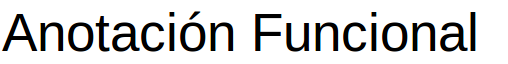

# 1. Anotacion de productos de genes
# 2. Gráficos en R<br/>

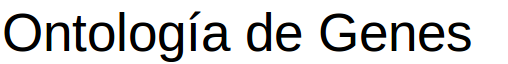

# IMPORTANTE
## Archivos requeridos para la Ontologia 
>### 1.- go.obo
>### 2.- OWLTools (Map2Slim)
>### 3.- GO slim (Saccharomyces)
>### 4.- Proteoma en estudio (IDs Uniprot)
>### 5.- Archivo en formato GAF (Gene Association Format, GOC)

In [79]:
## creamos dos directorios, uno para las descargas y otro para los resultados
os.makedirs('data',exist_ok=True)
os.makedirs('results',exist_ok=True)
os.makedirs('programs',exist_ok=True)

# 1.- Descargas (go.obo, OWLTools y GO slim)<br/>

In [80]:
if os.path.exists("./data/go.obo"): 
    print ('■■■ El archivo go.obo ya existe, no se descargará de la red')
else:
    ## descarga de la ontologia de genes
    output1=urllib.request.urlretrieve('http://snapshot.geneontology.org/ontology/go.obo','./data/go.obo')
if os.path.exists("./programs/owltools"):
    print ('■■■ El programa owltools ya existe, no se descargará de la red')
else: 
    ## descarga de owltools, una herramienta multitarea, una de ellas es hacer GO_slim
    output2=urllib.request.urlretrieve('http://build.berkeleybop.org/userContent/owltools/owltools','./programs/owltools')
    ## damos permisos de ejecucion a owltools
    !chmod +x ./programs//owltools
if os.path.exists("./data/goslim_yeast.txt"):
    print ('■■■ El archivo goslim_yeast.txt ya existe, no se descargará de la red')
else:
    ## descargamos el go-slim desde el Gene Ontology Consortium
    output3=urllib.request.urlretrieve('ftp://ftp.geneontology.org/go/GO_slims/goslim_yeast.obo','./data/goslim_yeast.obo')
    ## Ahora le hacemos una ligera edicion para obtener tres columnas: GO ID, término y aspecto
    Popen("grep -e '^id: GO:' -e '^name: ' -e '^namespace: ' -e '.Typedef.' ./data/goslim_yeast.obo | sed 's/id:/#id:/g' | perl -p -e 's/\n/\t/g' | sed 's/.Typedef.*//g' | perl -p -e 's/#/\n/g' | sed 's/id: //g; s/name: //g; s/namespace: //g' | sed '/^$/d' | sed 's/\t$//g' | sed 's/biological_process/P/g; s/molecular_function/F/g; s/cellular_component/C/g' | grep -v -e '\tC\tC' -v -e '\tF\tF' -v -e '\tP\tP'  > ./data/goslim_yeast.txt",
          shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
    if os.path.exists("./data/goslim_yeast.obo"): os.remove("./data/goslim_yeast.obo")


■■■ El archivo go.obo ya existe, no se descargará de la red


# 2.- Proteoma en estudio (IDs Uniprot) 
>## La lista de IDs de proteinas se obtuvo del siguiente articulo (*Saccharomyces cerevisiae*, strain ATCC 204508 / S288c, Baker's yeast)
https://www.ncbi.nlm.nih.gov/pubmed/29358734

In [81]:
Image(url= "https://raw.githubusercontent.com/eduardo1011/Programas/master/Quantitative_proteomics.png")

In [82]:
## contamos los IDs de las proteinas y vemos la lista 
proteome_list=pd.read_csv('proteome_list_sach.txt',header=None)
print('\n','Numero total de proteinas: ',proteome_list[0].count(),'\n')
print(proteome_list[1:10],'\n..........\n')


 Numero total de proteinas:  1500 

        0
1  O13329
2  O13525
3  O13539
4  O13547
5  O13563
6  O13585
7  O14464
8  O74700
9  P00044 
..........



## 3.- Obtencion del archivo GAF desde la base de datos de EMBL-EBI (Uniprot-GOA) y edicion (obtencion de ID y GO ID)

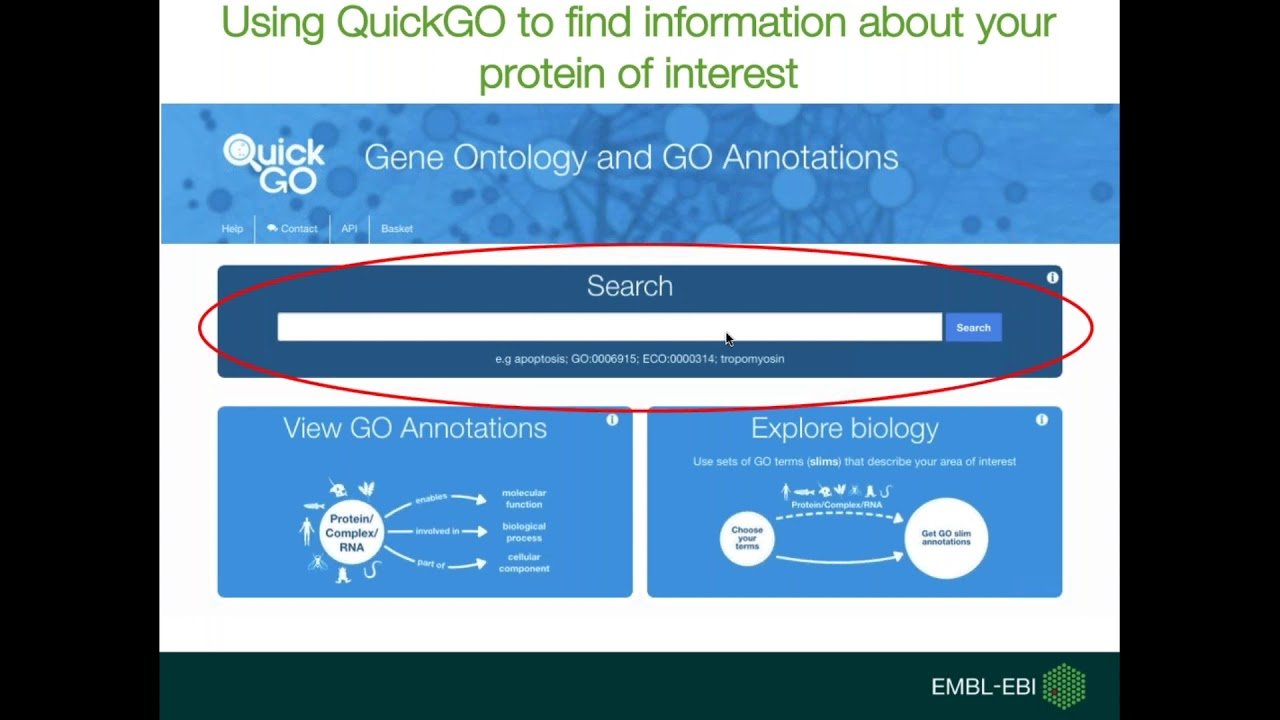

In [83]:
Image("https://i.ytimg.com/vi/Pa5Ll8WByr4/maxresdefault.jpg")

### Busqueda automatica del organismo en estudio<br/>

In [106]:
## Se extrae el primer identificador de la lista de proteínas
first_entry=proteome_list[0].iloc[0]

## Con el identificador de la proteína obtenemos el "organism" y el "id-organism" desde Uniprot
organism=requests.get("https://www.uniprot.org/uniprot/?query="+first_entry+"&sort=score&columns=organism&format=tab&limit=1").content.decode()
organismo=DataFrame(re.findall('[A-Z].*',organism))[0].iloc[1]

## id-organism (este id nos sirve para descargar el archivo GAF)
id_organism = requests.get("https://www.uniprot.org/uniprot/?query="+first_entry+"&sort=score&columns=organism-id,organism&format=tab&limit=1").content.decode()
id_organism=DataFrame(re.findall('[0-9]{1,30}',id_organism))[0].iloc[0]

print('\n',organismo,'\n')
print(id_organism,'\n')

KeyError: 0

### Han modificado la URL entonces por el momento este comando no corre, ejecutar el siguiente

In [ ]:
## Descarga del archivo con anotaciones (GAF)

## Registra el total de organismos en la base de datos
goa_proteomes = urllib.request.urlretrieve('https://www.ebi.ac.uk/inc/drupal/goa/proteomes_release.html', './data/goa_proteomes')

## Conversión html a tsv
out1 = Popen('sed "s/\t//g; s/<[^>]*>/#/g; s/#\{1,7\}/#/g; s/^[#]//g; 1,3d; s/#/\t/g" ./data/goa_proteomes | cut -f1-6 > ./data/salida',
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()

## Encuentra el id-"organism" y más información como el directorio para descarga
goa_id_organism = Popen('grep '+'^'+id_organism+' ./data/salida | cut -f3',
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read().decode()
goa_id_organism=re.sub("\n",'',goa_id_organism)
##
## Control de la descarga del archivo GAF desde Uniprot-GOA
if goa_id_organism == '':
    print('\n!!!!!!! ID-Organism not found in GOA-Uniprot (Complete Annotation) !!!!!!!\n')
    if os.path.exists("./data/goa_proteomes"): os.remove("./data/goa_proteomes")
    if os.path.exists("./data/salida"): os.remove("./data/salida")
else:
    ## Descarga del archivo GAF desde Uniprot-GOA
    out2 =urllib.request.urlretrieve("ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/proteomes/20180622/"+goa_id_organism+'.gz', './data/'+goa_id_organism+'.gz')
    out3 = Popen("gzip -d ./data/"+goa_id_organism+".gz",
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
    ## removemos filas que empiezan con el caracter "!"
    out3 = Popen("sed -i 's/^!.*//g;/^$/d' ./data/"+goa_id_organism,
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
    if os.path.exists("./data/goa_proteomes"): os.remove("./data/goa_proteomes")
    if os.path.exists("./data/salida"): os.remove("./data/salida")

In [85]:
## plan B si el anterior no fuunciona (que no tenga contenido la URL)
#wget ftp://ftp.geneontology.org/go/ontology/go.obo -O data/go.obo
!wget "ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/proteomes/20180622/71242.S_cerevisiae_ATCC_204508.goa.gz" -O ./data/71242.S_cerevisiae_ATCC_204508.goa.gz
!gzip -d ./data/*.gz

--2018-07-20 11:32:47--  ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/proteomes/20180622/71242.S_cerevisiae_ATCC_204508.goa.gz
           => “./data/71242.S_cerevisiae_ATCC_204508.goa.gz”
Resolviendo ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.192.4
Conectando con ftp.ebi.ac.uk (ftp.ebi.ac.uk)[193.62.192.4]:21... conectado.
Accediendo como anonymous... ¡Sesión iniciada!
==> SYST ... hecho.    ==> PWD ... hecho.
==> TYPE I ... hecho.  ==> CWD (1) /pub/databases/GO/goa/proteomes/20180622 ... hecho.
==> SIZE 71242.S_cerevisiae_ATCC_204508.goa.gz ... 1584080
==> PASV ... hecho.    ==> RETR 71242.S_cerevisiae_ATCC_204508.goa.gz ... hecho.
Longitud: 1584080 (1.5M) (no autenticado)

71242.S_cerevisiae_ 100%[===================>]   1.51M   377KB/s    in 4.1s    

2018-07-20 11:32:54 (377 KB/s) - “./data/71242.S_cerevisiae_ATCC_204508.goa.gz” guardado [1584080]



## 4.- Creando un GO slim usando Map2Slim: una opcion de OWLTools
>### Map2slim usa un fichero GO slim y un fichero .GAF, el script mapea los terminos del .GAF (anotacion completa) en los terminos del  GO slim creando una version corta de la ontologia.

### A partir del fichero GAF (gene association files) creamos el GO slim buscando los padres de cada término

In [86]:
## ejecutamos owltools
goslim = Popen("./programs/owltools ./data/go.obo --gaf ./data/71242.S_cerevisiae_ATCC_204508.goa --map2slim --idfile ./data/goslim_yeast.txt --write-gaf ./data/my.gaf", shell=True,
                stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()

In [87]:
## filtramos filas sin ! (caracteristico de ficheros GAF) y extraemos las columnas 2 y 5 con qacc y GO
output7 = Popen("grep -v '!' ./data/my.gaf | cut -f2,5 > ./data/slim", shell=True,
                stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
## abrimos el fichero slim y lo asignamos
my_gaf_goslim=pd.read_table('./data/slim', names=['Entry','GO']).drop_duplicates()
print(my_gaf_goslim.count(),'\n')
print(my_gaf_goslim[1:10])

Entry    38254
GO       38254
dtype: int64 

         Entry          GO
2   A0A0B7P3V8  GO:0003677
3   A0A0B7P3V8  GO:0003723
4   A0A0B7P3V8  GO:0016779
8   A0A0B7P3V8  GO:0008233
9   A0A0B7P3V8  GO:0004518
12  A0A0B7P3V8  GO:0043167
13  A0A0B7P3V8  GO:0005634
15  A0A0B7P3V8  GO:0005737
17  A0A0B7P3V8  GO:0006310


In [88]:
## abrimos el GO slim especifico (yeast en este caso)y lo asignamos
goslim_specific=pd.read_table('./data/goslim_yeast.txt',names=['GO','Term','Aspect'])
goslim_specific.head()

,GO,Term,Aspect
0,GO:0000054,ribosomal subunit export from nucleus,P
1,GO:0000278,mitotic cell cycle,P
2,GO:0000746,conjugation,P
3,GO:0000902,cell morphogenesis,P
4,GO:0000910,cytokinesis,P


### Ahora le asignaremos el GO a cada proteina del proteoma en estudio

In [89]:
proteome_list=pd.read_csv('proteome_list_sach.txt',names=['Entry'])
proteome_go=pd.merge(proteome_list,my_gaf_goslim,on="Entry",how='left')
proteome_go.head()

,Entry,GO
0,O13297,GO:0016791
1,O13297,GO:0005634
2,O13297,GO:0006397
3,O13297,GO:0016787
4,O13297,GO:0006354


In [90]:
proteome_go['Entry'].drop_duplicates().count()

1500

In [91]:
## asignacion de terminos y aspecto a cada proteina del proteoma en estudio
proteome_go_term=pd.merge(proteome_go,goslim_specific,on="GO",how='left').drop_duplicates()#.fillna('N')
proteome_go_term.head()

,Entry,GO,Term,Aspect
0,O13297,GO:0016791,phosphatase activity,F
1,O13297,GO:0005634,nucleus,C
2,O13297,GO:0006397,mRNA processing,P
3,O13297,GO:0016787,hydrolase activity,F
4,O13297,GO:0006354,"DNA-templated transcription, elongation",P


In [92]:
## analisis descriptivo
proteome_go_term.describe(include='all')

,Entry,GO,Term,Aspect
count,11916,11904,11904,11904
unique,1500,155,155,3
top,P39940,GO:0005737,cytoplasm,P
freq,41,788,788,4937


# Resultados
### Ahora extraemos las proteinas y sus categorias<br/>

## Funcion molecular

In [93]:
## Molecular Function
func=proteome_go_term[['GO','Term','Aspect']].groupby(['Aspect']).get_group('F')
function=func.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Molecular Function","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
function.to_csv('./results/Molecular_Function.csv',index=None)
function.head()

,GO,Molecular Function,Value
0,GO:0043167,ion binding,642
1,GO:0016740,transferase activity,328
2,GO:0016787,hydrolase activity,243
3,GO:0003677,DNA binding,197
4,GO:0016491,oxidoreductase activity,171


In [95]:
## matriz para ver intersecciones entre terminos
up_function=proteome_go_term[proteome_go_term.Aspect.str.contains("F")==True]
upset_function=up_function.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_function.to_csv('./results/Molecular_Function_matrix.csv',index=None)
upset_function.head()

GO,Entry,GO:0000988,GO:0003677,GO:0003682,GO:0003700,GO:0003723,GO:0003729,GO:0003735,GO:0003924,GO:0004386,...,GO:0016887,GO:0019843,GO:0019899,GO:0022857,GO:0030234,GO:0030674,GO:0032182,GO:0042393,GO:0043167,GO:0051082
0,O13297,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,O13329,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,O13547,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,O13563,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,O14464,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Proceso biologico

In [96]:
## Biological Process
pros=proteome_go_term[['GO','Term','Aspect']].groupby(['Aspect']).get_group('P')
process=pros.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Biological Process","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
process.to_csv('./results/Biological_Process.csv',index=None)
process.head()

,GO,Biological Process,Value
0,GO:0042221,response to chemical,197
1,GO:0055085,transmembrane transport,179
2,GO:0006366,transcription by RNA polymerase II,160
3,GO:0023052,signaling,152
4,GO:0055086,nucleobase-containing small molecule metabolic process,137


In [97]:
## matriz para ver intersecciones entre terminos
up_process=proteome_go_term[proteome_go_term.Aspect.str.contains("P")==True]
upset_process=up_process.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_process.to_csv('./results/Biological_Process_matrix.csv',index=None)
upset_process.head()

GO,Entry,GO:0000054,GO:0000746,GO:0000902,GO:0000910,GO:0001403,GO:0002181,GO:0005975,GO:0006091,GO:0006260,...,GO:0051186,GO:0051603,GO:0051604,GO:0051726,GO:0055085,GO:0055086,GO:0061025,GO:0070647,GO:0070925,GO:0071554
0,O13297,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,O13329,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,O13525,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,O13539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,O13547,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Componente celular

In [98]:
## Cellular Component
comp=proteome_go_term[['GO','Term','Aspect']].groupby(['Aspect']).get_group('C')
component=comp.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Cellular Component","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
component.to_csv('./results/Cellular_Component.csv',index=None)
component.head()

,GO,Cellular Component,Value
0,GO:0005737,cytoplasm,788
1,GO:0005634,nucleus,537
2,GO:0016020,membrane,365
3,GO:0005739,mitochondrion,311
4,GO:0005694,chromosome,178


In [99]:
## matriz para ver intersecciones entre terminos
up_component=proteome_go_term[proteome_go_term.Aspect.str.contains("C")==True]
upset_component=up_component.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_component.to_csv('./results/Cellular_Component_matrix.csv',index=None)
upset_component.head()

GO,Entry,GO:0005576,GO:0005618,GO:0005634,GO:0005694,GO:0005730,GO:0005737,GO:0005739,GO:0005740,GO:0005773,...,GO:0005815,GO:0005840,GO:0005856,GO:0005886,GO:0005933,GO:0005938,GO:0012505,GO:0016020,GO:0030427,GO:0031410
0,O13297,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,O13329,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O13525,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,O13539,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,O13547,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 5.- Proteinas anotadas y no anotadas

In [100]:
## de todas las proteinas sabemos cuantas tienen anotacion en Uniprot
nan=proteome_go_term[proteome_go_term['GO'].isnull()].reset_index(drop=True) ## proteinas que no tienen GO
print('Proteinas no anotadas: ',nan['Entry'].drop_duplicates().count(),'\n')
print(nan[['Entry']][1:10])

Proteinas no anotadas:  12 

    Entry
1  P25654
2  P32330
3  P32460
4  P32618
5  P34246
6  P36090
7  P38201
8  P38256
9  P38321


In [101]:
## solo las proteinas que tienen GO
no_nan=proteome_go_term[proteome_go_term['GO'].notnull()].reset_index(drop=True) 
print('Ptoreinas anotadas: ',no_nan['Entry'].drop_duplicates().count(),'\n')
print(no_nan[['Entry']][1:10])

Ptoreinas anotadas:  1488 

    Entry
1  O13297
2  O13297
3  O13297
4  O13297
5  O13297
6  O13329
7  O13329
8  O13329
9  O13329


In [102]:
sin_con=[nan['Entry'].drop_duplicates().reset_index(drop=True).rename(),no_nan['Entry'].drop_duplicates().reset_index(drop=True).rename()]
singo_congo=pd.concat(sin_con, axis=1,ignore_index=False).rename(columns={0:'Without GO',1:'Whith GO'},index=str, inplace=False)
singo_congo.count().to_csv('./results//Anotadas.csv')
singo_congo[['Without GO','Whith GO']].count()

Without GO      12
Whith GO      1488
dtype: int64

In [103]:
sin_nan=no_nan[['Entry','GO','Term','Aspect']].drop_duplicates()
frec=sin_nan.pivot_table(values="GO",index=["Entry"],aggfunc=len,columns="Aspect").reset_index()
#frec.to_csv('./results/Categories_frequences.csv',header=True,index=None)
frec[['F','C','P']].count().to_csv('./results/Total_categories_CFP.csv',header=None)
frec[['F','C','P']].count()

Aspect
F    1338
C    1397
P    1423
dtype: int64

In [104]:
# =================================================================================================

In [105]:
## Archivo para generar un diagrama de Venn, intersecciones entre categorias, total de proteinas por categoria
ff=proteome_go_term[proteome_go_term.Aspect.str.contains("F")==True]
pp=proteome_go_term[proteome_go_term.Aspect.str.contains("P")==True]
cc=proteome_go_term[proteome_go_term.Aspect.str.contains("C")==True]
cats=[pp[['Entry']],ff[['Entry']],cc[['Entry']]]
categorias=pd.concat(cats, axis=1, ignore_index=True).rename(columns={0:"Process",1:'Function',2:'Component'},index=str).reset_index(drop=True)
categorias.to_csv('./results/cats.csv',index=None) 
categorias.head()

,Process,Function,Component
0,NaN,O13297,NaN
1,NaN,NaN,O13297
2,O13297,NaN,NaN
3,NaN,O13297,NaN
4,O13297,NaN,NaN
